# Installing and Importing Requisite Packages


In [1]:
%load_ext autoreload
%autoreload 2
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
import datetime as dt
from datetime import timedelta
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json

os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# import python scientific stack
import pandas as pd
# import pandas_datareader.data as web
from pandas import Timestamp
pd.set_option('display.max_rows', 100)
# from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import numpy as np
# import scipy.stats as stats
# import statsmodels.api as sm
# from numba import jit
import math
# import pymc3 as pm
# from theano import shared, theano as tt
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from itertools import cycle
# from scipy import interp

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
# import pyarrow as pa
# import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
# import missingno as msno
# from google.colab import drive

# Defining Necessary Functions

In [2]:
class MultiProcessingFunctions:
    """ This static functions in this class enable multi-processing """

    def __init__(self):
        pass

    @staticmethod
    def lin_parts(num_atoms, num_threads):
        """Partition a list of atoms into subsets (molecules) of equal size."""
        parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
        parts = np.ceil(parts).astype(int)
        return parts

    @staticmethod
    def nested_parts(num_atoms, num_threads, upper_triangle=False):
        """Partition of atoms for nested loops (enables parallelization)."""
        # parts = [] [] 빈 리스트로 하면 첫번째 실행할 때, 빈 리스트에 [-1]인덱스를 참조하면 out of range
        parts = [0.0]
        num_threads_ = min(num_threads, num_atoms)

        for num in range(num_threads_):
            part = 1 + 4 * (
                parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_
            )
            part = (-1 + part ** 0.5) / 2.
            parts.append(part)

        parts = np.round(parts).astype(int)

        if upper_triangle:  # the first rows are heaviest
            parts = np.cumsum(np.diff(parts)[::-1])
            parts = np.append(np.array([0]), parts)
        return parts

    @staticmethod
    def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
        """
        Parallelize a function across pandas objects.
        :param func: function to be parallelized
        :param pd_obj: ('arg_name', atoms) where atoms is an index-like sequence
        :param num_threads: number of worker processes
        :param mp_batches: multiplier for number of jobs
        :param lin_mols: linear vs nested partitioning
        :return: pandas Series/DataFrame or list of results
        """
        atoms = pd_obj[1]
        n_jobs = max(1, int(num_threads) * int(mp_batches))
        if lin_mols:
            parts = MultiProcessingFunctions.lin_parts(len(atoms), n_jobs)
        else:
            parts = MultiProcessingFunctions.nested_parts(len(atoms), n_jobs)

        jobs = []
        for i in range(1, len(parts)):
            mol = atoms[parts[i - 1]:parts[i]]
            if len(mol) == 0:
                continue
            job = {pd_obj[0]: mol, 'func': func}
            job.update(kargs)
            jobs.append(job)

        if len(jobs) == 0:
            return pd.Series(dtype=float)

        out = (
            MultiProcessingFunctions.process_jobs_(jobs)
            if num_threads == 1
            else MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)
        )

        out = [o for o in out if o is not None]
        if len(out) == 0:
            return pd.Series(dtype=float)

        first = out[0]
        if isinstance(first, pd.DataFrame):
            out = [o.to_frame().T if isinstance(o, pd.Series) else o for o in out]
            return pd.concat(out, axis=0, copy=False).sort_index()
        elif isinstance(first, pd.Series):
            out = [o if isinstance(o, pd.Series) else pd.Series(o) for o in out]
            return pd.concat(out, axis=0, copy=False).sort_index()
        else:
            return out

    @staticmethod
    def process_jobs_(jobs):
        """Run jobs sequentially (debugging)."""
        out = []
        for job in jobs:
            out_ = MultiProcessingFunctions.expand_call(job)
            out.append(out_)
        return out

    @staticmethod
    def expand_call(kargs):
        """Expand arguments of a callback function."""
        func = kargs['func']
        del kargs['func']
        return func(**kargs)

    @staticmethod
    def report_progress(job_num, num_jobs, time0, task):
        """Report progress of async jobs."""
        msg = [float(job_num) / num_jobs, (time.time() - time0) / 60.]
        msg.append(msg[1] * (1 / msg[0] - 1))
        time_stamp = str(dt.datetime.fromtimestamp(time.time()))

        msg = (
            time_stamp + " " + str(round(msg[0] * 100, 2)) + "% " + task +
            " done after " + str(round(msg[1], 2)) +
            " minutes. Remaining " + str(round(msg[2], 2)) + " minutes."
        )

        if job_num < num_jobs:
            sys.stderr.write(msg + "\r")
        else:
            sys.stderr.write(msg + "\n")

    @staticmethod
    def process_jobs(jobs, task=None, num_threads=24):
        """Run jobs in parallel."""
        if task is None:
            task = jobs[0]['func'].__name__

        pool = mp.Pool(processes=num_threads)
        outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
        out = []
        time0 = time.time()

        for i, out_ in enumerate(outputs, 1):
            out.append(out_)
            MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

        pool.close()
        pool.join()
        return out


In [3]:
def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [4]:
def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    print('get_t_event over.')
    return event_timestamps

In [5]:
def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    print( 'vertical_barrier start')
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    print('vertical_barrier over')
    return t1

In [6]:
def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns 수익률(사이드 반영)
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out

In [7]:
def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking level; 
                  element 1 is stop loss level.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """
    print('get_events start')
    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    print('MultiProcessing mp_pandas start')
    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    print('MultiProcessing mp_pandas stop')
    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)
    print('get_events stop')
    return events

In [8]:
def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret = out_df.loc[date_time, 'ret']
        target = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df

In [9]:
def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df

In [10]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [11]:
def get_dollar_bars(time_bars, dollar_threshold):

    # initialize an empty list of dollar bars
    dollar_bars = []

    # initialize the running dollar volume at zero
    running_volume = 0

    # initialize the running high and low with placeholder values
    running_high, running_low = 0, math.inf

    # for each time bar...
    for i in range(len(time_bars)):

        # get the timestamp, open, high, low, close, and volume of the next bar
        next_close, next_high, next_low, next_open, next_timestamp, next_volume = [time_bars[i][k] for k in ['close', 'high', 'low', 'open', 'timestamp', 'vol']]

        # get the midpoint price of the next bar (the average of the open and the close)
        midpoint_price = ((next_open) + (next_close))/2

        # get the approximate dollar volume of the bar using the volume and the midpoint price
        dollar_volume = next_volume * midpoint_price

        # update the running high and low
        running_high, running_low = max(running_high, next_high), min(running_low, next_low)

        # if the next bar's dollar volume would take us over the threshold...
        if dollar_volume + running_volume >= dollar_threshold:

            # set the timestamp for the dollar bar as the timestamp at which the bar closed (i.e. one minute after the timestamp of the last minutely bar included in the dollar bar)
            bar_timestamp = next_timestamp + timedelta(minutes=1)
            
            # add a new dollar bar to the list of dollar bars with the timestamp, running high/low, and next close
            dollar_bars += [{'timestamp': bar_timestamp, 'open': next_open, 'high': running_high, 'low': running_low, 'close': next_close}]

            # reset the running volume to zero
            running_volume = 0

            # reset the running high and low to placeholder values
            running_high, running_low = 0, math.inf

        # otherwise, increment the running volume
        else:
            running_volume += dollar_volume

    # return the list of dollar bars
    return dollar_bars

In [12]:
## plot for grid search
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

# Implementation

Import and Format Data

In [13]:
# mount personal drive
# drive.mount('')

## Data Load

In [14]:
#download the data into your google drive to use the following code
infp=PurePath('BTCUSDT_1min.csv')

#import data and set timestamps as index
data = pd.read_csv(infp)   
data['open_time']= pd.to_datetime((data['open_time']))

data = data[['open_time', 'open', 'high', 'low', 'close', 'volume']]
data.rename(columns = {'open_time':'timestamp', 'open':'open', 'high':'high', 'low':'low','close':'close', 'volume':'vol'},
            inplace = True)

data.tail() #  ~ 2022-09-30 20:25:00

,timestamp,open,high,low,close,vol
4259707,2025-09-28 06:59:00,109410.00,109410.0,109409.99,109410.00,0.73075
4259708,2025-09-28 07:00:00,109410.00,109410.0,109409.99,109409.99,0.99541
4259709,2025-09-28 07:01:00,109409.99,109410.0,109409.99,109410.00,0.68273
4259710,2025-09-28 07:02:00,109410.00,109410.0,109409.99,109409.99,1.10861
4259711,2025-09-28 07:03:00,109409.99,109410.0,109409.99,109410.00,0.59584


In [15]:
data.head()

,timestamp,open,high,low,close,vol
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796


In [16]:
#download the data into your google drive to use the following code
infp=PurePath('ETHBTC_1min.csv')

#import data and set timestamps as index
data2 = pd.read_csv(infp)   
data2['open_time']= pd.to_datetime((data2['open_time']))

data2 = data2[['open_time', 'open', 'high', 'low', 'close', 'volume']]
data2.rename(columns = {'open_time':'timestamp', 'open':'open', 'high':'high', 'low':'low','close':'close', 'volume':'vol'},
            inplace = True)

data2.head()

,timestamp,open,high,low,close,vol
0,2017-07-14 04:00:00,0.08,0.08,0.08,0.08,0.043
1,2017-07-14 04:01:00,0.08,0.08,0.08,0.08,0.000
2,2017-07-14 04:02:00,0.08,0.08,0.08,0.08,0.306
3,2017-07-14 04:03:00,0.08,0.08,0.08,0.08,0.212
4,2017-07-14 04:04:00,0.08,0.08,0.08,0.08,0.165


In [17]:
# dollar bar : 5 million threshold
data_dict = data.to_dict('records') # 각 row를 딕셔너리로 해서 리스트 변환
data_dict[0]

{'timestamp': Timestamp('2017-08-17 04:00:00'),
 'open': 4261.48,
 'high': 4261.48,
 'low': 4261.48,
 'close': 4261.48,
 'vol': 1.775183}

In [18]:
dollar_bars = get_dollar_bars(data_dict, 1000000) #5,000,000 is an arbitrarily selected threshold
data_db = pd.DataFrame(dollar_bars)
data_db = data_db.set_index('timestamp')
data_db.head()

,open,high,low,close
timestamp,,,,
2017-08-17 14:39:00,4484.00,4485.39,4261.32,4484.00
2017-08-17 18:09:00,4231.87,4485.39,4218.68,4231.87
2017-08-17 22:39:00,4328.24,4369.69,4200.74,4341.96
2017-08-18 01:27:00,4202.75,4359.13,4134.61,4219.88
2017-08-18 05:39:00,4330.82,4330.82,4200.60,4295.40


In [19]:
data = data.set_index('timestamp')
data2 = data2.set_index('timestamp')
data['eth_close'] = data['close'].mul(data2['close']).dropna()
data.head()

,open,high,low,close,vol,eth_close
timestamp,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,300.783781
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,300.677244
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,302.126205
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,300.178651
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,299.778072


In [20]:
data_db = pd.concat([data_db, data['eth_close']], join = 'inner', axis = 1)
data_db.head()

,open,high,low,close,eth_close
timestamp,,,,,
2017-08-17 14:39:00,4484.00,4485.39,4261.32,4484.00,308.956568
2017-08-17 18:09:00,4231.87,4485.39,4218.68,4231.87,299.675642
2017-08-17 22:39:00,4328.24,4369.69,4200.74,4341.96,307.189328
2017-08-18 01:27:00,4202.75,4359.13,4134.61,4219.88,297.100590
2017-08-18 05:39:00,4330.82,4330.82,4200.60,4295.40,306.080515


## [Time bar] : Model Apply 

### Primary Model

Create Primary Bollinger Band Model

In [21]:
import copy
data_w = copy.deepcopy(data)

# compute bands
window = 50
data_w['avg'], data_w['upper'], data_w['lower'] = bbands(data_w['close'], window, no_of_stdev=2)

# compute sides
data_w['side'] = np.nan
long_signals = (data_w['close'] <= data_w['lower'])
short_signals = (data_w['close'] >= data_w['upper'])
data_w.loc[long_signals, 'side'] = 1
data_w.loc[short_signals, 'side'] = -1

print(data_w.side.value_counts())

# Remove Look ahead biase by lagging the signal
data_w['side'] = data_w['side'].shift(1) #다음 1분이 숏이다 롱이다. 편의상 1분이라는 기간을 뒀다. 그 다음 1분동안이 신호다.

# Drop the NaN values from our data set
data_w.dropna(axis=0, how='any', inplace=True)  

side
 1.0    57944
-1.0    55498
Name: count, dtype: int64


Implement Triple Barriers

In [22]:
close = data_w['close']

# determining daily volatility using the last 50 days
daily_vol = get_daily_vol(close=close, lookback=50)

# creating our event triggers using the CUSUM filter 
cusum_events = get_t_events(close, threshold=daily_vol.mean()*0.1)

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=0.5)

# determining timestamps of first touch   

pt_sl = [1, 2] # setting profit-take and stop-loss at 1% and 2%          2% 떨어지면 손절 , 1% 이익이 나면 손절 사용자에게 직접 입력받음
min_ret = 0.0005 # setting a minimum return of 0.05%                     0.05% 최소 수익률..


triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=1,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data_w['side'])

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|███████████████████████████████████████████████████████████████████████| 113440/113440 [00:01<00:00, 93059.17it/s]


get_t_event over.
vertical_barrier start
vertical_barrier over
get_events start
MultiProcessing mp_pandas start
MultiProcessing mp_pandas stop
get_events stop


Add Labels

In [60]:
daily_vol

timestamp
2017-08-18 05:18:00         NaN
2017-08-18 05:19:00    0.004795
2017-08-18 06:35:00    0.004079
2017-08-18 06:42:00    0.007376
2017-08-18 06:46:00    0.010103
                         ...   
2025-09-28 06:28:00    0.007829
2025-09-28 06:29:00    0.007675
2025-09-28 06:30:00    0.007525
2025-09-28 06:31:00    0.007377
2025-09-28 06:32:00    0.007232
Name: close, Length: 113397, dtype: float64

In [23]:
triple_barrier_events[-30:]

,t1,trgt,side
2025-09-24 13:24:00,2025-09-25 01:34:00,0.008445,-1.0
2025-09-24 13:58:00,2025-09-24 14:52:00,0.008135,1.0
2025-09-24 14:44:00,2025-09-25 04:18:00,0.007930,-1.0
2025-09-24 14:51:00,2025-09-25 01:40:00,0.007943,-1.0
2025-09-24 19:29:00,2025-09-25 09:26:00,0.008264,1.0
2025-09-25 01:34:00,2025-09-25 13:44:00,0.009505,1.0
2025-09-25 02:33:00,2025-09-25 04:18:00,0.009202,-1.0
2025-09-25 04:18:00,2025-09-25 17:15:00,0.009030,1.0
2025-09-25 04:20:00,2025-09-25 17:15:00,0.008677,1.0
2025-09-25 09:26:00,2025-09-25 13:02:00,0.008121,-1.0


In [24]:
triple_barrier_events['trgt']
print(triple_barrier_events[triple_barrier_events['trgt'] <= 1])

                                     t1      trgt  side
2017-08-18 05:19:00 2017-08-18 06:46:00  0.004795  -1.0
2017-08-18 06:46:00 2017-08-18 08:32:00  0.010103   1.0
2017-08-18 08:32:00 2017-08-18 08:48:00  0.009257  -1.0
2017-08-18 08:33:00 2017-08-18 08:48:00  0.008787  -1.0
2017-08-18 08:48:00 2017-08-18 10:14:00  0.009836   1.0
...                                 ...       ...   ...
2025-09-27 03:33:00 2025-09-27 15:38:00  0.014220  -1.0
2025-09-27 07:34:00 2025-09-27 20:17:00  0.013873   1.0
2025-09-27 21:39:00                 NaT  0.009831  -1.0
2025-09-28 00:26:00                 NaT  0.008603  -1.0
2025-09-28 01:09:00                 NaT  0.008144   1.0

[49444 rows x 3 columns]


In [25]:
events_ = triple_barrier_events.dropna(subset=['t1'])
prices = events_.index.union(events_['t1'].values)
prices = prices.drop_duplicates()
prices = close.reindex(prices, method='bfill')

In [26]:
prices.loc[events_.index]

2017-08-18 05:19:00      4290.77
2017-08-18 06:46:00      4254.92
2017-08-18 08:32:00      4320.71
2017-08-18 08:33:00      4311.09
2017-08-18 08:48:00      4270.02
                         ...    
2025-09-26 17:27:00    109951.54
2025-09-26 21:15:00    109408.00
2025-09-27 01:42:00    109370.94
2025-09-27 03:33:00    109617.49
2025-09-27 07:34:00    109433.48
Name: close, Length: 49441, dtype: float64

In [27]:
labels = get_bins(triple_barrier_events, data_w['close'])
labels.side.value_counts()

side
 1.0    25885
-1.0    23556
Name: count, dtype: int64

Evaluating Primary Model

In [28]:
labels.tail()

,ret,trgt,bin,side
2025-09-26 17:27:00,0.002437,0.014336,0,-1.0
2025-09-26 21:15:00,0.000465,0.014108,0,-1.0
2025-09-27 01:42:00,-0.000976,0.014265,0,1.0
2025-09-27 03:33:00,0.002874,0.014220,0,-1.0
2025-09-27 07:34:00,-0.000647,0.013873,0,1.0


In [29]:
labels['bin'].value_counts()

bin
0    37709
1    11732
Name: count, dtype: int64

In [30]:
labels25 = labels.loc[labels.index.year == 2025].copy()

In [31]:
labels25['bin'].value_counts()

bin
0    2270
1     772
Name: count, dtype: int64

In [32]:
labels25['side'].value_counts()

side
 1.0    1581
-1.0    1461
Name: count, dtype: int64

In [33]:
import numpy as np
import pandas as pd

labels25 = labels.loc[labels.index.year == 2025].copy()

# 1) side별 bin=1 비율(= 메타 히트율)
hit_rate = labels25.groupby('side')['bin'].mean()
print("Hit rate by side (2025):\n", hit_rate)

# 2) 로그수익률로 복원해서 타깃 초과 여유(r' - trgt) 확인
#    get_bins에서 ret는 exp(logret)-1 이었으므로 log1p로 복원
labels25['logret'] = np.log1p(labels25['ret'])
labels25['rprime'] = labels25['logret'] * labels25['side']   # 방향 통일된 수익률
labels25['margin'] = labels25['rprime'] - labels25['trgt']    # 타깃 대비 여유

print("\nMargin stats (2025):")
print(labels25['margin'].describe())

# 3) 타깃 크기와 실제 r' 분포 비교
print("\nTarget (trgt) stats (2025):")
print(labels25['trgt'].describe())

print("\nr' (side*logret) stats (2025):")
print(labels25['rprime'].describe())


Hit rate by side (2025):
 side
-1.0    0.230664
 1.0    0.275142
Name: bin, dtype: float64

Margin stats (2025):
count    3042.000000
mean       -0.015731
std         0.020132
min        -0.125945
25%        -0.024791
50%        -0.013743
75%        -0.001121
max         0.062516
Name: margin, dtype: float64

Target (trgt) stats (2025):
count    3042.000000
mean        0.016214
std         0.010402
min         0.003272
25%         0.009805
50%         0.013199
75%         0.019365
max         0.078225
Name: trgt, dtype: float64

r' (side*logret) stats (2025):
count    3042.000000
mean        0.000484
std         0.017658
min        -0.087982
25%        -0.009113
50%         0.001082
75%         0.010660
max         0.090221
Name: rprime, dtype: float64


In [34]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['bin'])

# setting predicted column to 1 
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     37709
           1       0.24      1.00      0.38     11732

    accuracy                           0.24     49441
   macro avg       0.12      0.50      0.19     49441
weighted avg       0.06      0.24      0.09     49441

Confusion Matrix
[[    0 37709]
 [    0 11732]]

Accuracy
0.23729293501345036


#### Graph

In [35]:
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

n = 2; m = 2
label_1 = labels[labels['bin'] == 1]
list_1 = random.sample(list(label_1.index), k = n*m)

fig = make_subplots(
    rows = n, cols = m
)

for idx, st in enumerate(list_1):
  et = triple_barrier_events.loc[st]['t1']
  gr_dt = data.loc[st:et]
  avg, upper, lower = bbands(gr_dt['close'], 20, no_of_stdev=2)
  fig.add_trace(go.Candlestick(x=gr_dt.index,
                open=gr_dt.open, high=gr_dt.high,
                low=gr_dt.low, close=gr_dt.close),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = avg,
                           line = dict(color='black', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = upper,
                           line = dict(color='blue', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = lower,
                           line = dict(color='red', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  
  fig.update_xaxes(rangeslider_visible=False, visible = False)

fig.update_layout(title = 'Price change in tripple barrier window ')
fig.update_traces(showlegend = False)
fig.show()
  


In [36]:
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

n = 2; m = 2
label_1 = labels[labels['bin'] == 0]
list_1 = random.sample(list(label_1.index), k = n*m)

fig = make_subplots(
    rows = n, cols = m
)

for idx, st in enumerate(list_1):
  et = triple_barrier_events.loc[st]['t1']
  gr_dt = data.loc[st:et]
  avg, upper, lower = bbands(gr_dt['close'], 20, no_of_stdev=2)
  fig.add_trace(go.Candlestick(x=gr_dt.index,
                open=gr_dt.open, high=gr_dt.high,
                low=gr_dt.low, close=gr_dt.close),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = avg,
                           line = dict(color='black', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = upper,
                           line = dict(color='blue', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = lower,
                           line = dict(color='red', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  
  fig.update_xaxes(rangeslider_visible=False, visible = False)

fig.update_layout(title = 'Price change in tripple barrier window ')
fig.update_traces(showlegend = False)
fig.show()

### Secondary Model

In [37]:
from sklearn.impute import SimpleImputer

# Get features at event dates
X = data_w.loc[labels.index]
X['rvi'] = (X['open'] - X['close']) / (X['high'] - X['low'])

X.replace([np.inf, -np.inf], np.nan, inplace=True)

X = X.loc[:,['close', 'eth_close', 'side', 'rvi']]
y = labels['bin'].loc[X.index]

# Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X[X.index.year < 2025]
X_test = X[X.index.year == 2025]
y_train = y[y.index.year < 2025]
y_test = y[y.index.year == 2025]

imp = SimpleImputer(strategy='median')

X_train = pd.DataFrame(
    imp.fit_transform(X_train),  # train으로 fit
    index=X_train.index, columns=X_train.columns
)
X_test = pd.DataFrame(
    imp.transform(X_test),       # test엔 transform만
    index=X_test.index, columns=X_test.columns
)

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Minmax Scaler
ms = MinMaxScaler() # max = 1 , min = 0
X_train_m = pd.DataFrame(ms.fit_transform(X_train), columns = X_train.columns)
X_test_m = pd.DataFrame(ms.transform(X_test), columns = X_test.columns)

# Standard Scaler
ss = StandardScaler() # mean = 0, var = 1
X_train_s = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns)
X_test_s = pd.DataFrame(ss.transform(X_test), columns = X_test.columns)

# Robust Scaler
rs = RobustScaler() # Scaling
X_train_r = pd.DataFrame(rs.fit_transform(X_train), columns = X_train.columns)
X_test_r = pd.DataFrame(rs.transform(X_test), columns = X_test.columns)

In [39]:
X_train

,close,eth_close,side,rvi
2017-08-18 05:19:00,4290.77,303.477581,-1.0,-0.017341
2017-08-18 06:46:00,4254.92,304.558664,1.0,1.000000
2017-08-18 08:32:00,4320.71,308.019095,-1.0,-0.017341
2017-08-18 08:33:00,4311.09,307.160851,-1.0,1.000000
2017-08-18 08:48:00,4270.02,306.502036,1.0,1.000000
...,...,...,...,...
2024-12-31 17:35:00,93871.36,3350.268838,1.0,0.859840
2024-12-31 17:37:00,93593.45,3340.350230,1.0,0.887933
2024-12-31 17:40:00,93446.68,3336.046476,1.0,-0.435015
2024-12-31 20:38:00,93730.37,3345.236905,1.0,0.846512


#### Decision Tree (Creating Secondary Model)

Grid Search

In [40]:
from sklearn.model_selection import GridSearchCV

# Setting random forest parameters
RANDOM_STATE = 0

# Fitting our model

grid_params = {
    'criterion': ['entropy', 'gini'], 
    'max_depth': list(range(1,50))
}

dt = DecisionTreeClassifier()
gs = GridSearchCV(dt, grid_params, cv=5, scoring='roc_auc')
gs.fit(X_train_m, y_train)

,estimator,DecisionTreeClassifier()
,param_grid,"{'criterion': ['entropy', 'gini'], 'max_depth': [1, 2, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [41]:
print("Best Parameters : ", gs.best_params_)
print("Best Score : ", gs.best_score_)
print("Best Test Score : ", gs.score(X_test_m, y_test))

print(pd.DataFrame(gs.cv_results_))

Best Parameters :  {'criterion': 'gini', 'max_depth': 34}
Best Score :  0.4739700318736821
Best Test Score :  0.4985631462418115
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.020510      0.000893         0.002083    1.677523e-04   
1        0.038546      0.000873         0.002001    7.294206e-07   
2        0.053036      0.002613         0.002199    3.974442e-04   
3        0.071800      0.001167         0.002200    3.998294e-04   
4        0.083013      0.004333         0.002104    2.083560e-04   
5        0.101327      0.005684         0.002800    3.998995e-04   
6        0.113236      0.008781         0.002400    4.899015e-04   
7        0.133441      0.008646         0.002200    4.000669e-04   
8        0.152074      0.009100         0.002601    4.907454e-04   
9        0.159962      0.010606         0.002600    4.899210e-04   
10       0.179396      0.004172         0.002400    4.897849e-04   
11       0.182227      0.011972         0.002392    4.7

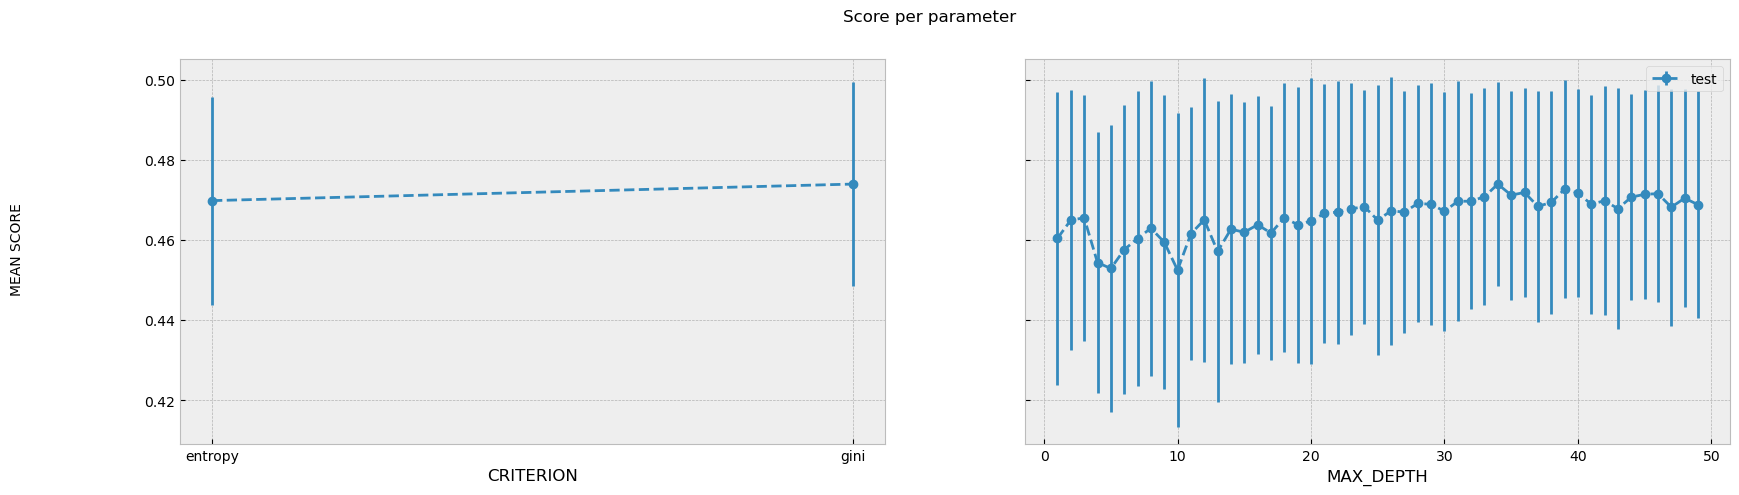

In [42]:
plot_search_results(gs)

In [43]:
from sklearn import tree 
###########
# Setting random forest parameters

clf = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 1)  

# Fitting our model
clf.fit(X_train_m, y_train)

# Performance Metrics
y_pred = clf.predict(X_test_m)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85      2270
           1       0.00      0.00      0.00       772

    accuracy                           0.75      3042
   macro avg       0.37      0.50      0.43      3042
weighted avg       0.56      0.75      0.64      3042

Confusion Matrix
[[2270    0]
 [ 772    0]]

Accuracy
0.7462195923734385


#### Random Forest (Creating Secondary Model)

In [44]:
###########
# Setting random forest parameters
n_estimator = 100
depth = 20
RANDOM_STATE = 0

clf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
clf.fit(X_train_m, y_train)


# Performance Metrics
y_pred = clf.predict(X_test_m)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2270
           1       0.29      0.24      0.26       772

    accuracy                           0.66      3042
   macro avg       0.52      0.52      0.52      3042
weighted avg       0.64      0.66      0.65      3042

Confusion Matrix
[[1811  459]
 [ 586  186]]

Accuracy
0.6564760026298487


Grid Search for Random Forest

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Setting random forest parameters
RANDOM_STATE = 0

# Fitting our model

grid_params = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [5, 10, 15, 30, 50, 100]
}

rf = RandomForestClassifier()
gs = GridSearchCV(rf, grid_params, cv=5, scoring='roc_auc')
gs.fit(X_train_s, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True, False], 'max_depth': [5, 10, ...], 'max_features': ['auto', 'sqrt'], 'n_estimators': [5, 10, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,5


In [46]:
print("Best Parameters : ", gs.best_params_)
print("Best Score : ", gs.best_score_)
print("Best Test Score : ", gs.score(X_test, y_test))

print(pd.DataFrame(gs.cv_results_))

Best Parameters :  {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 5}
Best Score :  0.46233410196081987
Best Test Score :  0.5154167903038049
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.001000  6.397442e-07         0.000000        0.000000   
1         0.001000  4.623108e-07         0.000000        0.000000   
2         0.000800  4.000428e-04         0.000000        0.000000   
3         0.001000  8.476443e-07         0.000000        0.000000   
4         0.000800  4.000190e-04         0.000000        0.000000   
..             ...           ...              ...             ...   
139       1.080115  5.798569e-02         0.006000        0.000895   
140       1.610200  6.142788e-02         0.008200        0.001720   
141       3.275124  1.467147e-01         0.015601        0.002577   
142       5.394307  1.864300e-01         0.021600        0.004499   
143      10.680366  5.297326e-01         0.041400        0.008163   



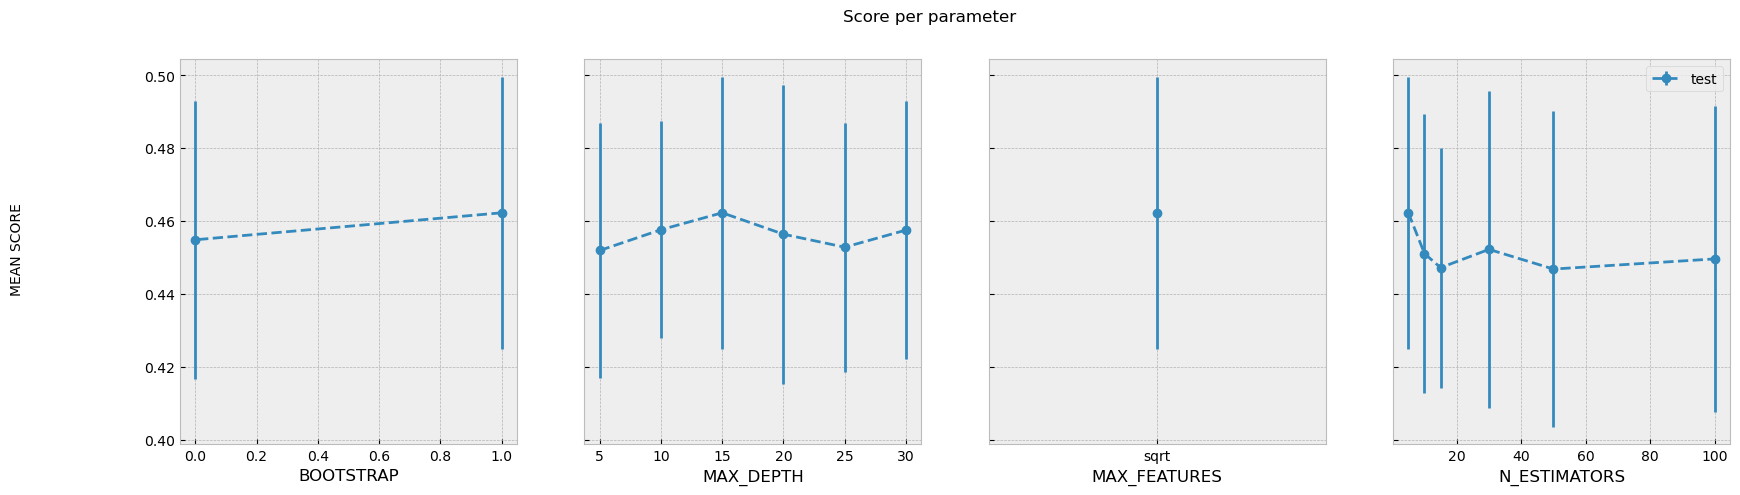

In [47]:
plot_search_results(gs)

In [64]:
###########
# Setting random forest parameters
n_estimator = 5
depth = 5
RANDOM_STATE = 0

clf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                             bootstrap = False, criterion='entropy', 
                             class_weight='balanced_subsample', max_features = 'sqrt',
                             random_state=RANDOM_STATE)

# Fitting our model
clf.fit(X_train_s, y_train)


# Performance Metrics
y_pred = clf.predict(X_test_s)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.05      0.10      2270
           1       0.26      0.97      0.41       772

    accuracy                           0.28      3042
   macro avg       0.54      0.51      0.25      3042
weighted avg       0.68      0.28      0.18      3042

Confusion Matrix
[[ 117 2153]
 [  24  748]]

Accuracy
0.28435239973701515


#### KNN (Creating Secondary Model)

Grid Search for KNN

In [49]:
# Grid serach for KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

grid_params = {
    'n_neighbors' : list(range(3,31)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, grid_params, cv=5, scoring='roc_auc')
gs.fit(X_train_m, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan', ...], 'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


In [50]:
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import GridSearchCV,StratifiedKFold
# from sklearn.neighbors import KNeighborsClassifier

# pipe = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),   # NaN만 처리
#     ("knn", KNeighborsClassifier())
# ])

# param_grid = {
#     "knn__n_neighbors": [3,5,7,9,11,15,21],
#     "knn__weights": ["uniform", "distance"],
#     "knn__metric": ["minkowski"],
#     "knn__p": [1, 2],
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #cv 교차검증 방식 
# #StratifiedKFold: 분류 문제에서 각 폴드마다 클래스 비율을 원본과 비슷하게 유지하며 나눔(불균형 데이터일수록 중요).
# #사용했을 때 Best Score 0.05정도의 상승 있었음
# gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)

# gs.fit(X_train_m, y_train)


In [51]:
print("Best Parameters : ", gs.best_params_)
print("Best Score : ", gs.best_score_)
print("Best Test Score : ", gs.score(X_test_m, y_test))

print(pd.DataFrame(gs.cv_results_))

Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best Score :  0.469367226051582
Best Test Score :  0.5052709365227912
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.036419      0.003184         0.042934        0.006140   
1         0.035529      0.005239         0.042786        0.005523   
2         0.034704      0.001423         0.044793        0.006383   
3         0.033847      0.001280         0.047168        0.009059   
4         0.033345      0.001383         0.048047        0.007068   
..             ...           ...              ...             ...   
163       0.034809      0.001835         0.095593        0.012912   
164       0.035539      0.001960         0.097764        0.013933   
165       0.034911      0.001207         0.096507        0.013995   
166       0.034847      0.001728         0.100307        0.013863   
167       0.036503      0.002237         0.109218        0.017859   

    param_metric  

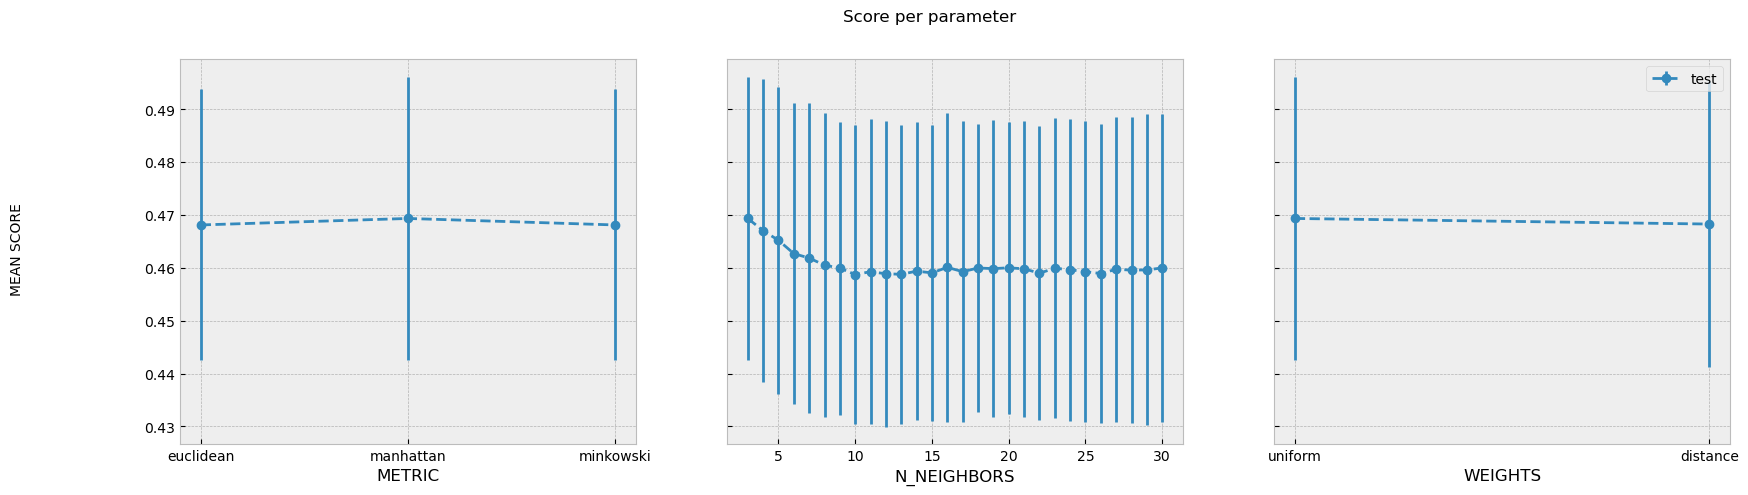

In [52]:
plot_search_results(gs)

In [53]:
from sklearn.neighbors import KNeighborsClassifier

#  활용
clf = KNeighborsClassifier(n_neighbors = 15, metric = 'manhattan', weights = 'uniform')     

# Fitting our model
clf.fit(X_train_m, y_train)

# Performance Metrics
y_pred = clf.predict(X_test_m)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      2270
           1       0.28      0.03      0.05       772

    accuracy                           0.74      3042
   macro avg       0.51      0.50      0.45      3042
weighted avg       0.63      0.74      0.64      3042

Confusion Matrix
[[2216   54]
 [ 751   21]]

Accuracy
0.7353714661406969


#### Graph

In [54]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

import seaborn as sns
from typing import Tuple
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba

In [55]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

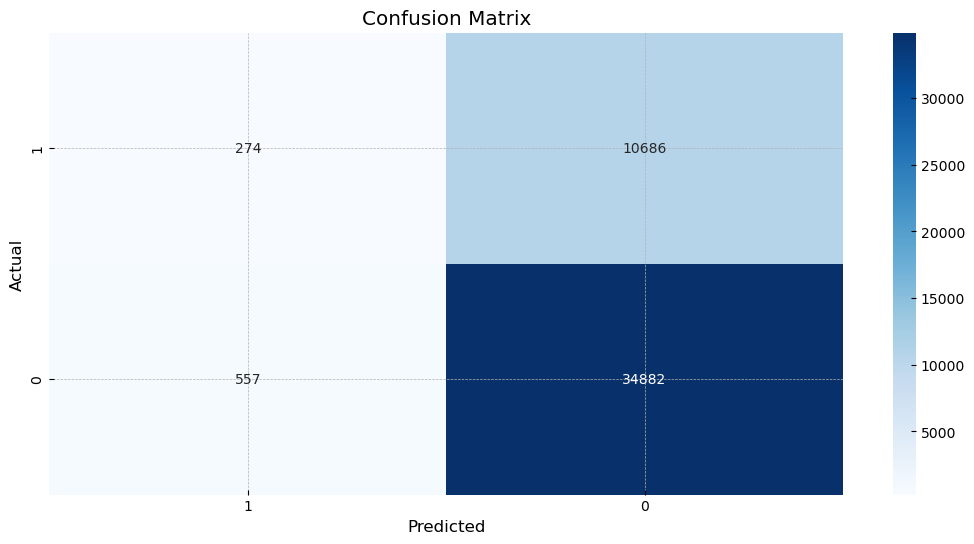

In [56]:
model = KNeighborsClassifier(n_neighbors = 15, metric = 'manhattan', weights = 'uniform')
kfold = KFold(n_splits=5, random_state=42, shuffle=True)  
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X_train_m.to_numpy(), y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [1, 0])

In [68]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. scale_pos_weight 계산
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# 2. XGBoost 모델 정의 (수정된 부분)
clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=10,     # <-- 파라미터를 이곳으로 이동
    random_state=RANDOM_STATE
)

# 3. 모델 학습 (수정된 부분)
# fit 메소드에서는 조기 종료 파라미터를 제거합니다.
clf.fit(X_train_s, y_train, 
        eval_set=[(X_test_s, y_test)], 
        verbose=True)

# 4. 예측 및 평가
y_pred = clf.predict(X_test_s)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

scale_pos_weight: 3.23
[0]	validation_0-logloss:0.69393
[1]	validation_0-logloss:0.69497
[2]	validation_0-logloss:0.69642
[3]	validation_0-logloss:0.69728
[4]	validation_0-logloss:0.69819
[5]	validation_0-logloss:0.69949
[6]	validation_0-logloss:0.69982
[7]	validation_0-logloss:0.70014
[8]	validation_0-logloss:0.70053
[9]	validation_0-logloss:0.70087
              precision    recall  f1-score   support

           0       0.70      0.12      0.21      2270
           1       0.25      0.84      0.38       772

    accuracy                           0.30      3042
   macro avg       0.47      0.48      0.29      3042
weighted avg       0.58      0.30      0.25      3042

Confusion Matrix
[[ 275 1995]
 [ 120  652]]

Accuracy
0.3047337278106509


In [75]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. scale_pos_weight 계산
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# 2. XGBoost 모델 정의
clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=10,
    random_state=RANDOM_STATE
)

# 3. 모델 학습
clf.fit(X_train_s, y_train, 
        eval_set=[(X_test_s, y_test)], 
        verbose=False) # 학습 과정 로그는 생략

# 4. '1' 클래스에 대한 예측 확률 구하기
# predict_proba의 결과는 [0일 확률, 1일 확률]이므로, 두 번째 열([:, 1])을 사용합니다.
y_pred_proba = clf.predict_proba(X_test_s)[:, 1]

# 5. 테스트할 임계값 리스트 정의
thresholds = [0.500, 0.502, 0.504, 0.506, 0.508, 0.510]

# 6. 각 임계값별로 성능 평가
for threshold in thresholds:
    print(f"============== Threshold: {threshold:.2f} 적용 결과 ==============")
    
    # 설정한 임계값보다 확률이 크면 1, 작으면 0으로 변환
    new_y_pred = (y_pred_proba >= threshold).astype(int)
    
    # 해당 예측 결과로 성능 리포트 출력
    print(classification_report(y_test, new_y_pred))
    
    # 혼동 행렬 출력
    print("Confusion Matrix")
    print(confusion_matrix(y_test, new_y_pred))
    print("\n")

scale_pos_weight: 3.23
============== Threshold: 0.50 적용 결과 ==============
              precision    recall  f1-score   support

           0       0.70      0.12      0.21      2270
           1       0.25      0.84      0.38       772

    accuracy                           0.30      3042
   macro avg       0.47      0.48      0.29      3042
weighted avg       0.58      0.30      0.25      3042

Confusion Matrix
[[ 275 1995]
 [ 120  652]]


============== Threshold: 0.50 적용 결과 ==============
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      2270
           1       0.30      0.10      0.15       772

    accuracy                           0.71      3042
   macro avg       0.52      0.51      0.49      3042
weighted avg       0.63      0.71      0.65      3042

Confusion Matrix
[[2077  193]
 [ 691   81]]


============== Threshold: 0.50 적용 결과 ==============
              precision    recall  f1-score   support

           0       0

In [81]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 모델 학습 및 평가 부분 ---

# 1. 테스트할 가중치 리스트 정의
weights_to_test = [3.2,3.22,3.225, 3.23]

# 2. 각 가중치별로 모델을 학습하고 평가
for weight in weights_to_test:
    print(f"============== scale_pos_weight: {weight:.2f} 적용 결과 ==============")
    
    # 2-1. XGBoost 모델 정의 (현재 테스트하는 가중치 적용)
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=weight,  # <-- 수동으로 설정한 가중치 적용
        early_stopping_rounds=10,
        random_state=RANDOM_STATE
    )
    
    # 2-2. 모델 학습
    clf.fit(X_train_s, y_train, 
            eval_set=[(X_test_s, y_test)], 
            verbose=False) # 학습 로그 생략
    
    # 2-3. 예측 및 평가
    y_pred = clf.predict(X_test_s)
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

============== scale_pos_weight: 3.20 적용 결과 ==============
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      2270
           1       0.30      0.10      0.15       772

    accuracy                           0.71      3042
   macro avg       0.52      0.51      0.49      3042
weighted avg       0.63      0.71      0.65      3042

Confusion Matrix
[[2077  193]
 [ 691   81]]


============== scale_pos_weight: 3.22 적용 결과 ==============
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      2270
           1       0.30      0.10      0.15       772

    accuracy                           0.71      3042
   macro avg       0.52      0.51      0.49      3042
weighted avg       0.63      0.71      0.65      3042

Confusion Matrix
[[2077  193]
 [ 691   81]]


============== scale_pos_weight: 3.23 적용 결과 ==============
              precision    recall  f1-score   support

           0       0.7

In [57]:
X

,close,eth_close,side,rvi
2017-08-18 05:19:00,4290.77,303.477581,-1.0,NaN
2017-08-18 06:46:00,4254.92,304.558664,1.0,1.000000
2017-08-18 08:32:00,4320.71,308.019095,-1.0,NaN
2017-08-18 08:33:00,4311.09,307.160851,-1.0,1.000000
2017-08-18 08:48:00,4270.02,306.502036,1.0,1.000000
...,...,...,...,...
2025-09-26 17:27:00,109951.54,4028.624426,-1.0,-0.272857
2025-09-26 21:15:00,109408.00,4015.273600,-1.0,1.000000
2025-09-27 01:42:00,109370.94,4011.726079,1.0,-0.999488
2025-09-27 03:33:00,109617.49,4026.250408,-1.0,0.048413


In [58]:
# cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', verbose=0)
# print(cv_results, cv_results.mean())

In [62]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=15, metric='manhattan', weights='uniform'))
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(pipe, X, y, cv=kfold, scoring='accuracy', verbose=0)
print(cv_results, cv_results.mean())

[0.75376681 0.75293285 0.75111246 0.75768608 0.76173139] 0.7554459189560758


In [ ]:
y_pred.shape

### Model Save

In [129]:
import joblib
joblib.dump(clf, './timebar_knn_model.pkl')

['./timebar_knn_model.pkl']

# Visualization

## Buy/Sell Print

In [132]:
y_pred = pd.Series(y_pred, index = X_test.index, name = 'y_pred')
y_proba = pd.Series(clf.predict_proba(X_test_m)[:,1], index = X_test.index, name = 'y_proba')
df_pred = pd.concat([X_test, y_test, y_pred, y_proba], axis = 1)
df_pred

,close,eth_close,side,rvi,bin,y_pred,y_proba
2025-01-01 00:18:00,93824.52,3350.473609,-1.0,0.069663,0,0,0.266667
2025-01-01 00:52:00,94158.21,3360.506515,-1.0,0.436875,0,0,0.266667
2025-01-01 00:59:00,94401.14,3364.456630,-1.0,0.675029,1,0,0.333333
2025-01-01 05:28:00,93881.60,3351.573120,-1.0,-0.999793,0,0,0.200000
2025-01-01 08:26:00,93469.26,3334.983197,1.0,0.999901,1,0,0.200000
...,...,...,...,...,...,...,...
2025-09-26 17:27:00,109951.54,4028.624426,-1.0,-0.272857,0,0,0.333333
2025-09-26 21:15:00,109408.00,4015.273600,-1.0,1.000000,0,0,0.266667
2025-09-27 01:42:00,109370.94,4011.726079,1.0,-0.999488,0,0,0.133333
2025-09-27 03:33:00,109617.49,4026.250408,-1.0,0.048413,0,0,0.266667


In [135]:
simul = data[data.index.year == 2025]
buy_list = df_pred[df_pred['y_pred'] == 1].index
sell_list = triple_barrier_events.loc[buy_list]['t1']
simul['num_coin'] = pd.Series([0]*len(simul), index = simul.index)

simul

,open,high,low,close,vol,eth_close,num_coin
timestamp,,,,,,,
2025-01-01 00:00:00,93576.00,93610.93,93537.50,93610.93,8.21827,3338.165764,0
2025-01-01 00:01:00,93610.93,93652.00,93606.20,93652.00,12.14029,3338.693800,0
2025-01-01 00:02:00,93652.00,93702.15,93635.98,93702.15,11.60597,3342.355691,0
2025-01-01 00:03:00,93702.14,93702.15,93654.48,93677.98,8.72958,3340.556767,0
2025-01-01 00:04:00,93677.98,93677.99,93659.92,93661.20,5.24749,3340.895004,0
...,...,...,...,...,...,...,...
2025-09-28 06:59:00,109410.00,109410.00,109409.99,109410.00,0.73075,4006.594200,0
2025-09-28 07:00:00,109410.00,109410.00,109409.99,109409.99,0.99541,4006.593834,0
2025-09-28 07:01:00,109409.99,109410.00,109409.99,109410.00,0.68273,4007.688300,0


In [136]:
for b_idx, s_idx in zip(buy_list, sell_list):
  prd = simul.loc[b_idx:s_idx][:-1]
  num_coins = df_pred.loc[b_idx]['y_proba']
  prd['num_coin'] += (num_coins * prd['close'])   
  print(f'Buy Bitcoins : {np.round(num_coins, 2)} coins at {str(b_idx)} dollar [{simul.close.loc[b_idx]}]')
  print(f'Sell Bitcoins : {np.round(num_coins, 2)} coins at {str(s_idx)} dollar [{simul.close.loc[s_idx]}]')
print(f'Cryptocurrency Exchanges : Buy [{len(buy_list)}] Sell [{len(sell_list)}]')

Buy Bitcoins : 0.6 coins at 2025-01-17 01:38:00 dollar [101092.02]
Sell Bitcoins : 0.6 coins at 2025-01-17 14:36:00 dollar [103173.46]
Buy Bitcoins : 0.53 coins at 2025-01-18 11:45:00 dollar [103800.0]
Sell Bitcoins : 0.53 coins at 2025-01-19 02:28:00 dollar [105300.01]
Buy Bitcoins : 0.53 coins at 2025-01-20 06:54:00 dollar [108044.01]
Sell Bitcoins : 0.53 coins at 2025-01-20 12:20:00 dollar [105756.82]
Buy Bitcoins : 0.53 coins at 2025-01-23 14:32:00 dollar [103806.0]
Sell Bitcoins : 0.53 coins at 2025-01-24 02:48:00 dollar [103021.42]
Buy Bitcoins : 0.53 coins at 2025-01-30 19:57:00 dollar [105746.27]
Sell Bitcoins : 0.53 coins at 2025-01-31 11:11:00 dollar [104608.44]
Buy Bitcoins : 0.73 coins at 2025-02-03 01:56:00 dollar [93188.4]
Sell Bitcoins : 0.73 coins at 2025-02-03 07:48:00 dollar [95209.52]
Buy Bitcoins : 0.53 coins at 2025-02-03 04:28:00 dollar [93490.36]
Sell Bitcoins : 0.53 coins at 2025-02-03 14:33:00 dollar [96058.01]
Buy Bitcoins : 0.53 coins at 2025-02-07 06:29:00 d

In [137]:
def buy_or_sell(df):
  buy_df = df[df['y_pred'] == 1]

  for i in range(len(buy_df)):
    row = buy_df.iloc[i]
    next_rows = df.loc[row.name:].iloc[1:]
    for x in range(len(next_rows)-1):
      if next_rows['y_proba'].iloc[x+1] > next_rows['y_proba'].iloc[x]:
        next_row = next_rows.iloc[x+1]
        break

    

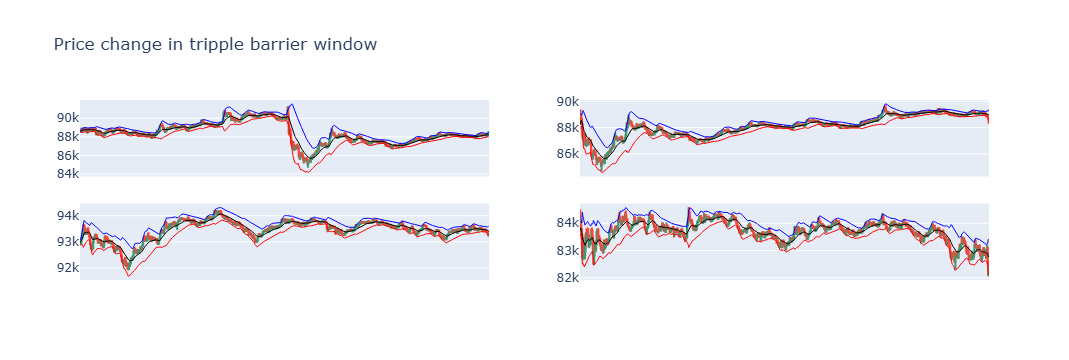

In [138]:
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

n = 2; m = 2
label_1 = df_pred[(df_pred['bin'] == 0) & (df_pred['y_pred'] == 1)]
list_1 = random.sample(list(label_1.index), k = n*m)

fig = make_subplots(
    rows = n, cols = m
)

for idx, st in enumerate(list_1):
  et = triple_barrier_events.loc[st]['t1']
  gr_dt = data.loc[st:et]
  avg, upper, lower = bbands(gr_dt['close'], 20, no_of_stdev=2)
  fig.add_trace(go.Candlestick(x=gr_dt.index,
                open=gr_dt.open, high=gr_dt.high,
                low=gr_dt.low, close=gr_dt.close),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = avg,
                           line = dict(color='black', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = upper,
                           line = dict(color='blue', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  fig.add_trace(go.Scatter(x=gr_dt.index, y = lower,
                           line = dict(color='red', width=1)),
                row = idx//n + 1, col = idx%m + 1)
  
  fig.update_xaxes(rangeslider_visible=False, visible = False)

fig.update_layout(title = 'Price change in tripple barrier window ')
fig.update_traces(showlegend = False)
fig.show()

In [139]:
buy_or_sell(df_pred)

## Cumulative log return graph

In [140]:
X = data[data.index.year == 2022]
profit = X['close'].pct_change()
profit_acc = (1 + profit).cumprod() - 1
profit

timestamp
2022-01-01 00:00:00         NaN
2022-01-01 00:01:00    0.001357
2022-01-01 00:02:00    0.001209
2022-01-01 00:03:00   -0.000812
2022-01-01 00:04:00   -0.000210
                         ...   
2022-12-31 23:55:00   -0.000069
2022-12-31 23:56:00    0.000075
2022-12-31 23:57:00   -0.000166
2022-12-31 23:58:00   -0.000082
2022-12-31 23:59:00    0.000362
Name: close, Length: 525600, dtype: float64

In [141]:
X = data[data.index.year == 2022]

btc_prf = X['close'].pct_change()
btc_prf_cum = (1 + btc_prf).cumprod() - 1
# log_profit = np.log(profit+1)
# log_profit_acc1 = log_profit.cumsum()

# account return
btc_prf_ac = X['close'].pct_change()
buy_df = df_pred[df_pred['y_pred'] == 1]
idx_srs = vertical_barriers.loc[buy_df.index]
s_idx = idx_srs.index
e_idx = idx_srs


for i in range(len(idx_srs)): 
  if i > 0:
    btc_prf_ac.loc[e_idx[i-1]:s_idx[i]][1:] = 0
  
  if i < len(idx_srs)-1:
    btc_prf_ac.loc[e_idx[i]:s_idx[i+1]][1:] = 0

btc_prf_ac_cum = (1 + btc_prf_ac).cumprod() - 1

In [142]:
X = data2[data2.index.year == 2022]
profit = X['close'].pct_change()
profit_acc = (1 + profit).cumprod() - 1
log_profit = np.log(profit+1)
log_profit_acc2 = log_profit.cumsum()

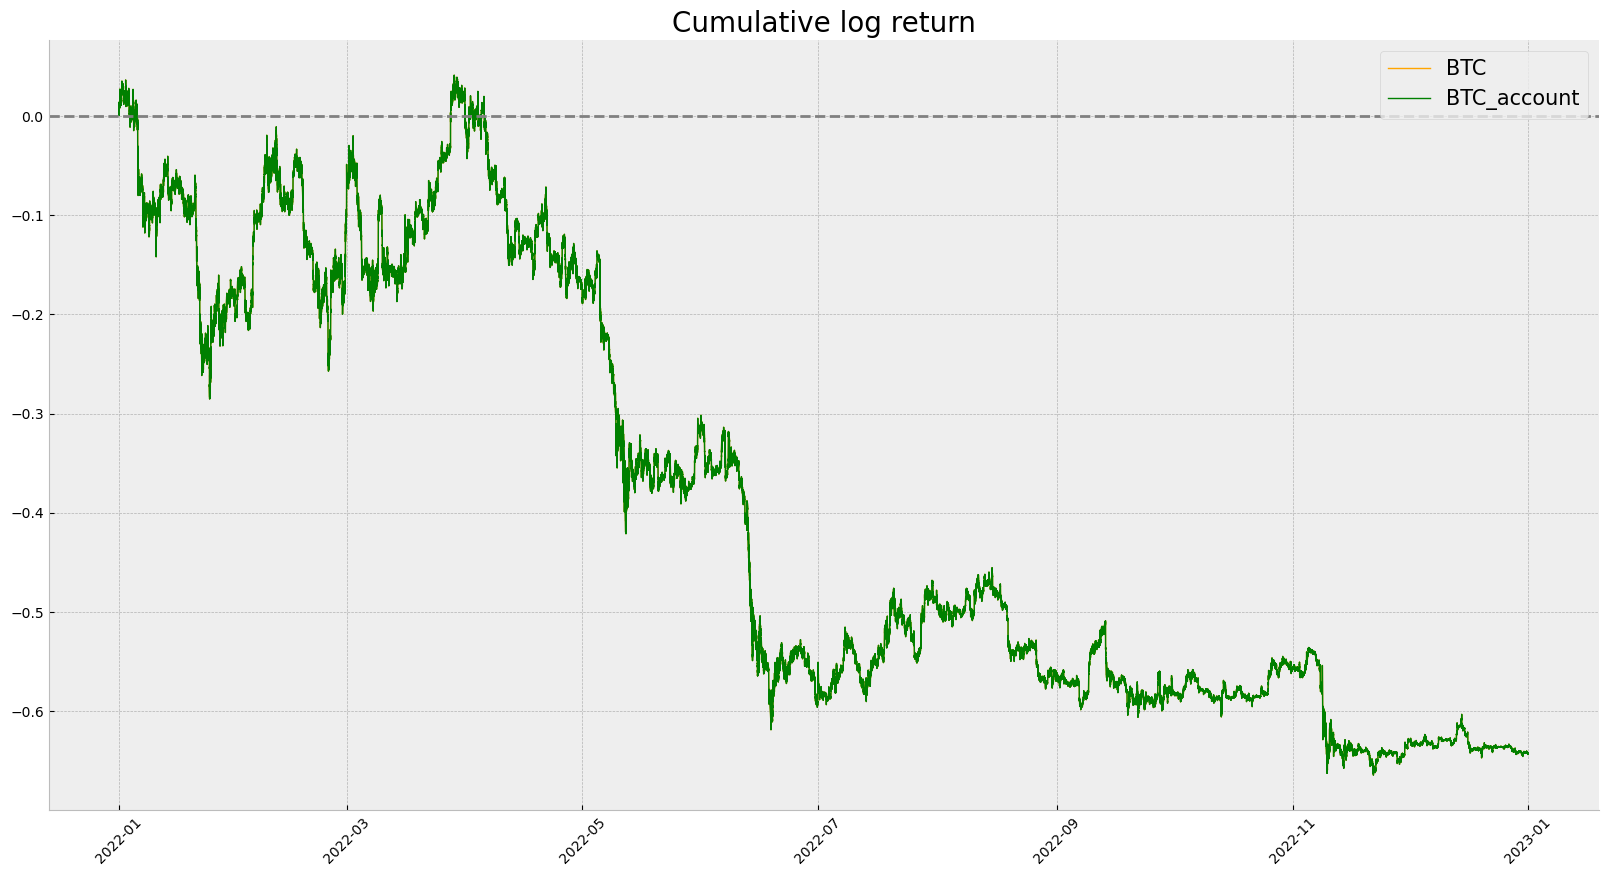

In [143]:
fig = plt.figure(figsize=(20,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.spines['right'].set_visible(False) ## 오른쪽 축 숨김
ax.spines['top'].set_visible(False) ## 위쪽 축 숨김
 
args_plot = [btc_prf_cum.index, btc_prf_cum] ## 데이터 인자
config_plot = dict( ## 키워드 인자
    color= 'orange', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=1, # 선 두께 
)

ax.plot(label = 'BTC', *args_plot,**config_plot) ## 선그래프 생성

args_plot2 = [btc_prf_ac_cum.index, btc_prf_ac_cum] ## 데이터 인자
config_plot2 = dict( ## 키워드 인자
    color= 'green', # 선 색깔
    linestyle='solid', # 선 스타일
    linewidth=1, # 선 두께 
)

ax.plot(label = 'BTC_account', *args_plot2,**config_plot2) ## 선그래프 생성

ax.axhline(0, ls = '--', color = 'gray')
# ax.text(0,mean_sales+10,f'Mean of Sales : {mean_sales}',fontsize=13) ## 평균 매출 텍스트 출력
 
ax.legend(loc='upper right', fontsize=15) ## 범례 생성
 
plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 45도 회전 
plt.title('Cumulative log return',fontsize=20) ## 타이틀 설정
plt.show()